# Code tester for four factor model
- specifically tests for implementing Z residual matrix

In [15]:
# #!/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on Sat Dec 11 15:13:44 2021
# simulationJSE.py
#
# New version updated August 9, 2022
# @author: alec kercheval
# """
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy 
from scipy.optimize import minimize
from numpy import linalg as la


# '''
# class to support simulation experiments for JSE
# Creates betas, factor returns, specific returns, and total returns
# for each of NumExperiments experimental runs.
# All randomness is called here.  Computations appear in the main program.
# Specific returns can be Normal, double exponential or Student t.
# In addition to beta, we add the option to consider a four-factor model
# with beta, loading2, loading3, loading4 and corresponding factors:
# factor, factor2, factor3, factor 4.
# Beta and three extra loadings will be generated once and stay constant across experiments.
# '''
#
#
#

class SimulationJSE:
    # 'simulation class for JSE estimation '

    def __init__(self, Rng, NormalFlag, MaxAssets, NumExperiments, NumPeriods, BetaMean=1, BetaStDev=0.5,
                 Factor1StDev=0.16 / np.sqrt(252), SpecificStDev=0.6 / np.sqrt(252), FactorFlag=1,
                 Factor2StDev=.04 / np.sqrt(252), Factor3StDev=.04 / np.sqrt(252), Factor4StDev=.08 / np.sqrt(252)):
        self.rng = Rng  # random number generator
        self.maxAssets = MaxAssets  # maximum number of assets in the simulation
        self.numExperiments = NumExperiments  # number of trials
        self.numPeriods = NumPeriods  # length of sample (days)
        self.betaMean = BetaMean  # mean of distribution of betas
        self.betaStDev = BetaStDev  # st deviation of betas

        self.factor1StDev = Factor1StDev  # std dev of beta factor (mean zero)
        self.factor2StDev = Factor2StDev
        self.factor3StDev = Factor3StDev
        self.factor4StDev = Factor4StDev
        self.specificStDev = SpecificStDev  # std dev of spec return (mean 0)

        self.normalFlag = NormalFlag  # 0 for normal specific returns
        self.factorFlag = FactorFlag  # 0 for one factor, 1 for four factors

        self.betas = self.CreateBetas()
        # populate vector of betas of size maxAssets, fixed across experiments
        self.exposures234 = self.CreateExposures234()
        # create maxAssets x 3 matrix of exposures for the other three factors

        self.factor1Matrix = self.CreateFactors1()
        # populate factor matrix of size NumPeriods x numExperiments

        self.factor234Matrix = self.CreateFactors234()
        # populate factor matrix of size 3 x NumPeriods x numExperiments

        self.specMatrix = self.CreateSpecMatrix()
        # populate array of specific returns of size
        # numAssets x numPeriods x numExperiments
        self.returnsMatrix = self.CreateReturnsMatrix()

    # end def __init__

    # create N-dim beta and exposure vectors
    def CreateBetas(self):
        return self.rng.normal(self.betaMean, self.betaStDev, self.maxAssets)

    def CreateExposures234(self):
        # only called if factorFlag is not zero, size maxAssets x 3
        return self.rng.normal(0, 1, (self.maxAssets, 3))

    # create periods x E factor matrix
    def CreateFactors1(self):
        return self.rng.normal(0, self.factor1StDev, (self.numPeriods, self.numExperiments))

    # create 3 x periods x E factor matrix
    def CreateFactors234(self):
        factors234 = np.zeros((3, self.numPeriods, self.numExperiments))  # initialize
        row1 = self.rng.normal(0, self.factor2StDev, (self.numPeriods, self.numExperiments))
        row2 = self.rng.normal(0, self.factor3StDev, (self.numPeriods, self.numExperiments))
        row3 = self.rng.normal(0, self.factor4StDev, (self.numPeriods, self.numExperiments))
        factors234[0, :, :] = row1
        factors234[1, :, :] = row2
        factors234[2, :, :] = row3
        return factors234

    # create assets x periods x E specific returns matrix
    def CreateSpecMatrix(self):
        if self.normalFlag == 0:
            return self.rng.normal(0, self.specificStDev, (self.maxAssets, self.numPeriods, self.numExperiments))
        elif self.normalFlag == 1:
            return self.rng.laplace(0, self.specificStDev / np.sqrt(2),
                                    (self.maxAssets, self.numPeriods, self.numExperiments))
        elif self.normalFlag == 2:
            df = 5  # degrees of freedom
            multiplier = np.sqrt((df - 2) / df) * self.specificStDev  # var = df/(df-2)
            return multiplier * self.rng.standard_t(df, (self.maxAssets, self.numPeriods, self.numExperiments))

    def CreateReturnsMatrix(self):
        N = self.maxAssets
        T = self.numPeriods
        Ex = self.numExperiments
        b = self.betas
        F = self.factor1Matrix
        Z = self.specMatrix
        Rtot = np.zeros((N, T, Ex))  # matrix to hold returns for each of Ex experiments
        if self.factorFlag == 0:
            for e in range(Ex):
                f = F[:, e]
                z = Z[:, :, e]

                R = np.outer(b, f) + z  # one factor model of returns
                # outer product of N dim b and T dim f
                Rtot[:, :, e] = R[:, :]
        else:
            bb = self.CreateExposures234() #this creates exposure matrix which we dont loop through. Exposures stay constant
            F234 = self.CreateFactors234() #this is a matrix of factor returns [ [F2]   [F3]   [F4] ]  where [Fi] is (T, exp) dimensional.
            for e in range(Ex):
                f = F[:, e]
                z = Z[:, :, e]
                ff = F234[:, :, e]

                R = np.outer(b, f) + np.matmul(bb, ff) + z  # four factor model of returns
                Rtot[:, :, e] = R[:, :]

        return Rtot

    def GetReturnsMatrix(self):
        return self.returnsMatrix

    def GetBetaVector(self):
        return self.betas
    
    def GetExposure234(self):
        return self.exposures234
    
    
########## USED FOR COMPUTING PCA ##############    
def ComputePCA_GPS(S, Srank, Sdim):
    evalues, evectors = la.eigh(S)
    h = [] # all our eigenvectors \beta, F1, F2, F3
    sp2 = [] # corresponding eigenvalues

    for i in range(1, 5): 
        h.append(evectors[:, -i])
        sp2.append(evalues[-i])

    lp2 = (np.sum(evalues ) -sp2[0] ) /(Srank -1)
    psi2 = (sp2[0] - lp2) / sp2[0]  # this is the psi^2 term from the GPS paper
    all_ones = np.ones(Sdim)
    q = all_ones / la.norm(all_ones) #north pole, unit vector

    hq = np.dot(h[0], q)  # inner product of h and q
    if hq < 0:
        h[0] = -h[0]  # choose e-vector h with positive mean
        hq = -hq
    elif hq == 0:
        print("error: h is orthogonal to q")

    tau = (1 - psi2) * hq / (psi2 - hq * hq)  # equation (21) from the dispersion bias
    h_shr = h[0] + tau * q  # h_GPS before normalizing

    h_shr_norm = (1/la.norm(h_shr))*h_shr #h_GPS normalized

    for i in range(1,4):  # now lets normalize the rest of the principal componenets
        h[i] = (1/la.norm(h[i]))*h[i]

    # up to here we have computed a list of our first four principal components normalized except for PCA, and their respective eigenvalues
    # h_shr_norm which is our corrected beta vector

    # now depending on the flag we will return two different things

    if FactorFlag == 0: 
        return h[0], h_shr_norm, sp2[0], lp2 # PCA principal comp, JSE prinpcal comp, leading eigenval, avg of rest eigenvals
    elif FactorFlag == 1: 
        return h, h_shr_norm, sp2 # Principal Components list, JSE princiapl comp, Corresponding eigenvalues. 
    else: 
        print('please correct flag')
        
def Compute_Zmatrix_cost(
    x, Bstar, Returns, 
    ) -> float:
    error = Returns - np.matmul(Bstar, x)
    returnVALUE = np.linalg.norm(error, 2)**2
    return returnVALUE

def getJSE_BSTAR(
    h, h_JSE
    ) -> list:
    H = np.array(h)
    H[0] = np.array(h_JSE)
    return H


def Compute_Zmatrix( # Function returns the JSE and PCA residuals matrix (keep at low experiments for quick tests)
    Returns: list
    ) -> list:

    numFactors = 4
    initialGuess = np.random.randn(numFactors)  # The initial guess for scipy optimizer
    Z = np.zeros((MaxAssets, NumPeriods, NumExperiments))  # The Residuals matrix
    Z_jse = np.zeros((MaxAssets, NumPeriods, NumExperiments))  # The Residuals matrix for JSE

    for t in range(NumExperiments): # Looping through all the experiments
        R_exper = Returns[:, :, t] 
        S = np.matmul(R_exper, R_exper.transpose()) / NumPeriods  # Create the Sample covariance matrix for experiment i
        h, h_JSE, sp2 = ComputePCA_GPS(S, NumPeriods, len(S))

        Bstar = np.array(h).T  # This is the BSTAR in better betas, factor exposures
        Bstar_JSE = np.array(getJSE_BSTAR(h,h_JSE)).T  # This is the BSTAR for JSE

        psi_exp_i = np.zeros((4, NumPeriods)) 
        psi_exp_i_jse = np.zeros((4,NumPeriods))

        for j in range(NumPeriods):
            R_day = R_exper[:, j]

            psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient 
            args =(Bstar,np.reshape(R_day, (MaxAssets,))),
            options = {'maxiter':10000, 'maxfev':10000, 'xatol': 1e-8, 'disp': True})

            psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
            args =(Bstar_JSE,np.reshape(R_day, (MaxAssets,))),
            options = {'maxiter':10000, 'maxfev':10000, 'xatol': 1e-8, 'disp': True})

            
            psi_exp_i[:, j] = psi_day.x
            psi_exp_i_jse[:, j] = psi_day_jse.x

        Z[:, :, t] = R_exper - np.matmul(Bstar, psi_exp_i)   # Residuals for regular PCA
        Z_jse[:, :, t] = R_exper - np.matmul(Bstar_JSE, psi_exp_i_jse)  # Residuals for JSE

    return Z, Z_jse

### Define the Experiments

In [5]:
DayString = "d220809"
MaxAssets = 500  # default 500
NumExperiments = 10  # default 400
NumPeriods = 252  # default 252

BetaMean = 1.0
BetaStDev = 0.5

Factor1StDev = 0.16 / np.sqrt(252)  # default 0.16/sqrt(252)
SpecificStDev = 0.6 / np.sqrt(252)  # daily vol from annual
Factor2StDev = .04 / np.sqrt(252)
Factor3StDev = .04 / np.sqrt(252)
Factor4StDev = .08 / np.sqrt(252)

FactorFlag = 1  # 0 for one factor; 1 for four factors
NormalFlag = 2  # 0 for Normal specific returns, 1 for double exponential, 2 for student's t

# create simulationGPS object, which
# creates beta, factor, specific, total returns  x numExperiments

rng = np.random.default_rng()  # makes a random number generator, random seed

sim = SimulationJSE(rng, NormalFlag, MaxAssets, NumExperiments, NumPeriods, BetaMean, BetaStDev, Factor1StDev,
                         SpecificStDev, FactorFlag, Factor2StDev, Factor3StDev, Factor4StDev)

# get returns matrix (assets x periods x numExperiments) from sim object
Rtot = sim.GetReturnsMatrix() #if our factor flag is now 1, we produce 4 factor returns

# get true betas -- one beta for all experiments
betaVector = sim.GetBetaVector()


In [6]:
Z, Z_jse = Compute_Zmatrix(Rtot)

<ipython-input-3-84912329fbaa>:227: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-3-84912329fbaa>:231: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient


Optimization terminated successfully.
         Current function value: 0.646777
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.650020
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.682748
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.683584
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.731593
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.734165
         Iterations: 3
         Function evaluations: 30
         Grad

<ipython-input-3-84912329fbaa>:231: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-3-84912329fbaa>:227: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-3-84912329fbaa>:231: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient



         Current function value: 0.679076
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.680394
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.711472
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.712792
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.660393
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.660689
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization term

<ipython-input-3-84912329fbaa>:231: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-3-84912329fbaa>:227: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-3-84912329fbaa>:231: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient



         Current function value: 0.573219
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.740854
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.744575
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.681195
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.680971
         Iterations: 2
         Function evaluations: 25
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.651624
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization term

In [8]:
def ComputeMRPortfolio(
    h, **kwargs  # computes weights for one factor covariance matrix:
    ) -> list:
    
    our_args = kwargs
    all_ones = np.ones(MaxAssets)
    
    if 'svar' in our_args:
        
        d2 = kwargs['svar']
        sigma2 = kwargs['mvar']
        Omega = sigma2*np.diag([1]*4) # this creates Omega diagonal (17)
        Delta = d2*np.diag([1]*MaxAssets) # this creates Delta diagonal in (17)
        cov_est = np.dot(np.dot(np.array(h).T, Omega), np.array(h)) + Delta # this is (17)
        w_num = np.dot(np.linalg.inv(cov_est),all_ones) # numerator of solving for w
        w = w_num/np.dot(all_ones.T,w_num) # final computation solving for w
    
    elif 'svar_l' in our_args:
        
        d2 = kwargs['svar_l']
        sigma2_l = kwargs['mvar_l']
        Omega = np.diag(sigma2_l) # we are given the real market variances
        Delta = np.diag(d2) # we are given the real d2 or specific variances
        cov_est = np.dot(np.dot(np.array(h).T, Omega), np.array(h)) + Delta # this is (17)
        w_num = np.dot(np.linalg.inv(cov_est),all_ones) # numerator of solving for w
        w = w_num/np.dot(all_ones.T,w_num) # final computation solving for w
        
    else: 
        
        p_eta = kwargs['p_eta']
        delta2 = kwargs['delta2']
        q = all_ones / la.norm(all_ones)  # north pole, unit vector
        hq = np.dot(h, q) # hq is just the h vector in the direction of the north pole
        k2 = delta2 / p_eta
        rho = (1 + k2) / hq
        w = ((rho * q) - h) / ((rho - hq) * np.sqrt(MaxAssets))
    
    return w

In [9]:
exposures234 = sim.GetExposure234()

In [49]:
f_VFR_raw = np.zeros(NumExperiments)  # var forecast ratio
f_VFR_Epca = np.zeros(NumExperiments)  # var forecast ratio
f_VFR_Ejse = np.zeros(NumExperiments)  # var forecast ratio

f_TrueVarR_Epca = np.zeros((NumExperiments))  # ratio of true min var to true var of est portfolio
f_TrueVarR_Ejse = np.zeros((NumExperiments))
f_TrueVarR_raw = np.zeros((NumExperiments))

f_trerrorraw = np.zeros((NumExperiments))  # pca tracking error
f_trerrorEpca = np.zeros(NumExperiments)  # pca tracking error
f_trerrorEjse = np.zeros((NumExperiments))  # gps tracking error

f_trueVar_Epca = np.zeros((NumExperiments))  # true variance of the PCA portfolio (min var with PCA cov estimate)
f_trueVar_Ejse = np.zeros((NumExperiments))  # true variance of the GPS portfolio
f_trueVar_raw = np.zeros((NumExperiments))
f_trueVar_TT = np.zeros((NumExperiments))

f_estVar_Epca = np.zeros((NumExperiments))  # estimated variance of the PCA portfolio (min var with PCA cov estimate)
f_estVar_Ejse = np.zeros((NumExperiments))  # est variance of the GPS portfolio
f_estVar_raw = np.zeros((NumExperiments))

for exper in range(NumExperiments):
    Y = Rtot[:, :, exper]  # matrix of returns for trial exper
    S = np.matmul(Y, Y.transpose()) / NumPeriods  # sample covariance matrix for trial exper
    b = betaVector / la.norm(betaVector)  # normalized beta
     
    
    # tracking error notation and formulas from MAPS paper, section 3


    ### we use these to compute the weights of the portfolio ###

    if FactorFlag == 0:
        h, h_GPS, sp2, lp2 = ComputePCA_GPS(S, NumPeriods, MaxAssets)  # defined above
        p_eta_true = np.dot(betaVector, betaVector) * (Factor1StDev) ** 2
        p_eta_obs = sp2 - lp2
        delta2_true = (SpecificStDev) ** 2
        delta2_obs = (NumPeriods / MaxAssets) * lp2

        delta2_raw = ((NumPeriods - 1) / (MaxAssets - 1)) * lp2 
        p_eta_raw = sp2 - delta2_raw

        w_Epca = ComputeMRPortfolio(h, p_eta = p_eta_obs, delta2 = delta2_obs)  # estimated evalues and PCA evector
        w_Ejse = ComputeMRPortfolio(h_GPS, p_eta = p_eta_obs, delta2 = delta2_obs)  # estimated evalues and GPS evector
        w_raw = ComputeMRPortfolio(h, p_eta = p_eta_raw, delta2 = delta2_raw)  # PCA evalue and evector

        w_TT = ComputeMRPortfolio(b, p_eta = p_eta_true, delta2 = delta2_true)  # true optimal portfolio
    
    elif FactorFlag == 1: # four factor main loop implementation

        ## retrieve principal components and define true values
        h, h_GPS, sp2 = ComputePCA_GPS(S, NumPeriods, MaxAssets)  # defined above

        h_GPS = getJSE_BSTAR(h, h_GPS)
        true_mvar = np.array([Factor1StDev**2, Factor2StDev**2, Factor3StDev**2, Factor4StDev**2])
        true_svar = np.array([SpecificStDev**2]*MaxAssets)
        betaVector = betaVector.reshape((MaxAssets, 1))
        true_bstar = np.concatenate([betaVector, exposures234], axis = 1)
        
        ## regular residuals ##
        z = Z[:, :, exper]
        z = np.sum(z**2, axis = 1) # square and sum across time
        d2n = (1/NumPeriods)*z # this is the calculation for equation (21) in better betas
        d2n_avg = np.sum(d2n)/len(d2n) # (22) bb
        sigma2 = sp2[0] - d2n_avg # (23) bb
        d2_mp = (np.trace(S) - np.sum(sp2))/(MaxAssets - 4*(1 - MaxAssets/NumPeriods)) # Marchenko-Pastur correction
        sigma2_mp = sp2[0] - d2_mp*(1 + MaxAssets/NumPeriods) # Marchenko-Pastur correction for market variance
        
        ## jse residuals ##
        z_jse = Z_jse[:, :, exper]
        z_jse = np.sum(z_jse**2, axis = 1) # square and sum across time
        d2n_jse = (1/NumPeriods)*z_jse # this is the calculation for equation (21) in better betas
        d2n_avg_jse = np.sum(d2n_jse)/len(d2n_jse) # (22) bb
        sigma2_jse = sp2[0] - d2n_avg_jse # (23) bb
        d2_mp_jse = (np.trace(S) - np.sum(sp2))/(MaxAssets - 4*(1 - MaxAssets/NumPeriods)) # Marchenko-Pastur correction
        sigma2_mp_jse = sp2[0] - d2_mp_jse*(1 + MaxAssets/NumPeriods) # Marchenko-Pastur correction for market variance
        
        ## weights ##
        w_Epca = ComputeMRPortfolio(h, mvar = sigma2_mp, svar = d2_mp)  # weights 4 factor corrected market and specific variance
        w_Ejse = ComputeMRPortfolio(h_GPS, mvar = sigma2_mp_jse, svar = d2_mp_jse)  # weights 4 factor corrected beta vector and variances
        w_raw = ComputeMRPortfolio(h, mvar = sigma2, svar = d2n)  # weights 4 factor regular variance estimates as well as regular beta vector

        w_TT = ComputeMRPortfolio(true_bstar.T, mvar_l = true_mvar, svar_l = true_svar)  # true optimal portfolio (make sure to transpose before putting in)

        
        # true sigma
        Omega = np.diag(true_mvar) # we are given the real market variances
        Delta = np.diag(true_svar) # we are given the real d2 or specific variances
        true_sigma = np.dot(np.dot(np.array(true_bstar), Omega), np.array(true_bstar).T) + Delta
        
        # pca sigma
        
        Omega = sigma2_mp*np.diag([1]*4) # we are given the real market variances
        Delta = d2_mp*np.diag([1]*MaxAssets) # we are given the real d2 or specific variances
        pca_sigma = np.dot(np.dot(np.array(h).T, Omega), np.array(h)) + Delta

        # raw sigma

        Omega = sigma2*np.diag([1]*4) # we are given the real market variances
        Delta = d2n*np.diag([1]*MaxAssets) # we are given the real d2 or speci
        raw_sigma = np.dot(np.dot(np.array(h).T, Omega), np.array(h)) + Delta

        # jse sigma

        Omega = sigma2_mp_jse*np.diag([1]*4) # we are given the real market variances
        Delta = d2_mp_jse*np.diag([1]*MaxAssets) # we are given the real d2 or specis
        jse_sigma = np.dot(np.dot(np.array(h_GPS).T, Omega), np.array(h_GPS)) + Delta

        f_TrackErr2_Epca = np.dot(np.dot(np.array(w_TT - w_Epca).reshape(1,MaxAssets), true_sigma), np.array(w_TT - w_Epca))
        f_TrackErr2_Ejse = np.dot(np.dot(np.array(w_TT - w_Ejse).reshape(1,MaxAssets), true_sigma), np.array(w_TT - w_Ejse))
        f_TrackErr2_raw = np.dot(np.dot(np.array(w_TT - w_raw).reshape(1,MaxAssets), true_sigma), np.array(w_TT - w_raw))

        f_trerrorEpca[exper] = np.sqrt(252 * f_TrackErr2_Epca) * 100
        f_trerrorEjse[exper] = np.sqrt(252 * f_TrackErr2_Ejse) * 100
        f_trerrorraw[exper] = np.sqrt(252 * f_TrackErr2_raw) * 100

        ### variance forecast ratios = estimated / true variances of the estimated portfolio ###

        # denominator using our estimates and true sigma
        f_trueVar_Epca[exper] = np.dot(np.dot(w_Epca.reshape(1,MaxAssets), true_sigma), w_Epca.reshape(MaxAssets,1))
        f_trueVar_Ejse[exper] = np.dot(np.dot(w_Ejse.reshape(1,MaxAssets), true_sigma), w_Ejse.reshape(MaxAssets,1))
        f_trueVar_raw[exper] = np.dot(np.dot(w_raw.reshape(1,MaxAssets), true_sigma), w_raw.reshape(MaxAssets,1))
        f_trueVar_TT[exper] = np.dot(np.dot(w_TT.reshape(1,MaxAssets), true_sigma), w_TT.reshape(MaxAssets,1))

        # numerator using our estimates and estimated sigma
        f_estVar_Epca[exper] = np.dot(np.dot(w_Epca.reshape(1,MaxAssets), pca_sigma), w_Epca.reshape(MaxAssets,1))
        f_estVar_Ejse[exper] = np.dot(np.dot(w_Ejse.reshape(1,MaxAssets), jse_sigma), w_Ejse.reshape(MaxAssets,1))
        f_estVar_raw[exper] = np.dot(np.dot(w_raw.reshape(1,MaxAssets), raw_sigma), w_raw.reshape(MaxAssets,1))

        # numerator / denominator
        f_VFR_Epca[exper] = f_estVar_Epca[exper] / f_trueVar_Epca[exper]
        f_VFR_Ejse[exper] = f_estVar_Ejse[exper] / f_trueVar_Ejse[exper]
        f_VFR_raw[exper] = f_estVar_raw[exper] / f_trueVar_raw[exper]

        # true variance ratios
        # true variance / estimated weights and true sigma
        f_TrueVarR_Epca[exper] = f_trueVar_TT[exper] / f_trueVar_Epca[exper]
        f_TrueVarR_Ejse[exper] = f_trueVar_TT[exper] / f_trueVar_Ejse[exper]
        f_TrueVarR_raw[exper] = f_trueVar_TT[exper] / f_trueVar_raw[exper]
    

### Tracking Error

In [27]:
import seaborn as sns

Text(0.5, 1.0, 'Four Factor Tracking Error 10 Experiments')

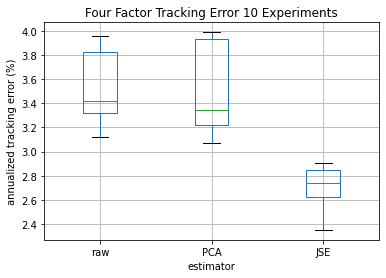

In [19]:
column_names = ['raw', 'PCA', 'JSE']

#### tracking error

data_tr = np.array([f_trerrorraw, f_trerrorEpca, f_trerrorEjse]).transpose()

df_tr = pd.DataFrame(data_tr, columns=column_names)

FigTrE = plt.figure()
bp_tr = df_tr.boxplot()
plt.ylabel("annualized tracking error (%)")
plt.xlabel("estimator")
plt.title("Four Factor Tracking Error " + str(NumExperiments) + " Experiments")
# FigVar.savefig("TE_boxplot_E" + str(NumExperiments) + "T" + str(NumPeriods) + "f" + str(
#         NormalFlag), bbox_inches="tight", dpi = 400)

### Variance Forecast Ratio

Text(0.5, 1.0, 'Four Factor Variance Forecast Ratio')

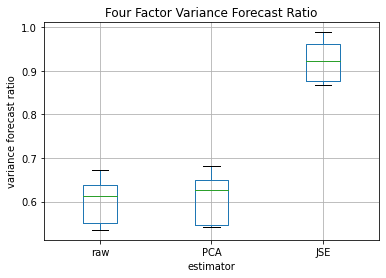

In [14]:
data_vf = np.array([f_VFR_raw, f_VFR_Epca, f_VFR_Ejse]).transpose()

df_vf = pd.DataFrame(data_vf, columns=column_names)

FigVF = plt.figure()
bp_vf = df_vf.boxplot()
plt.ylabel("variance forecast ratio")
plt.xlabel("estimator")
plt.title('Four Factor Variance Forecast Ratio')
# FigVar.savefig("VarianceForecastRatio_boxplot_E" + str(NumExperiments) + "T" + str(NumPeriods) + "f" + str(
#         NormalFlag), bbox_inches="tight", dpi = 400)


### True Variance Ratio

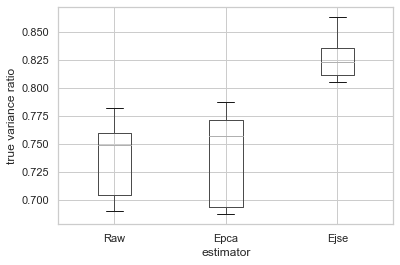

In [51]:
data_var = np.array([f_TrueVarR_raw, f_TrueVarR_Epca, f_TrueVarR_Ejse]).transpose()

df_var = pd.DataFrame(data_var, columns=column_names)

FigVar = plt.figure()
bp_var = df_var.boxplot()
plt.ylabel("true variance ratio")
plt.xlabel("estimator")

FigVar.savefig(DayString + "trueVarRatio_boxplot_E" + str(NumExperiments) + "T" + str(NumPeriods) + "f" + str(
        NormalFlag) + ".pdf", format="pdf", bbox_inches="tight")

### Attempt at filling with colors

In [61]:
# sns.set(style = 'whitegrid')

# fig, ax = plt.subplots(figsize = (8,6))

# g = sns.boxplot(data = df_var['Raw'], width = 0.7)

# xvalues = ['raw', 'PCA', 'JSE']

# plt.xticks(np.arange(3), xvalues)

# palette = ['plum', 'g', 'orange']
# color_dict = dict(zip(xvalues, palette))

# mybox = g.artists
# mybox.set_facecolor(color_dict[xvalues[0]])

# plt.ylabel('true variance ratio')
# plt.xlabel('estimator')
# plt.title('True Variance Ratio')
